In [1]:
import os
import matplotlib.pyplot as plt
import sys
import numpy as np
from scipy import ndimage
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img

Using TensorFlow backend.


In [2]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [3]:
!ls "/content/drive/My Drive/Riffle"

Image0.jpg     Image138.webp  Image176.jpg   Image23.jpeg  Image62.webp
Image100.jpg   Image139.jpg   Image177.jpg   Image24.jpg   Image63.jpeg
Image101.jpg   Image13.jpg    Image178.jpg   Image25.jpg   Image64.jpg
Image102.webp  Image140.jpg   Image179.png   Image26.jpg   Image65.jpg
Image103.jpg   Image141.jpg   Image17.jpg    Image27.png   Image66.png
Image104.jpg   Image142.jpg   Image180.jpg   Image28.jpg   Image67.webp
Image105.jpg   Image143.jpg   Image181.webp  Image29.jpg   Image68.jpg
Image106.jpg   Image144.webp  Image182.jpg   Image2.webp   Image69.jpg
Image107.jpg   Image145.jpg   Image183.jpeg  Image30.jpg   Image6.jpg
Image108.webp  Image146.jpg   Image184.webp  Image31.jpg   Image70.jpeg
Image109.jpg   Image147.jpg   Image185.jpg   Image32.jpeg  Image71.gif
Image10.jpg    Image148.jpg   Image186.jpg   Image34.jpg   Image72.jpg
Image110.jpg   Image149.jpg   Image187.jpg   Image35.jpeg  Image73.jpg
Image111.png   Image14.jpg    Image188.jpg   Image36.jpg   Image74.jpg
Ima

In [0]:
image = "/content/drive/My Drive/Riffle"



In [5]:
files = [f for f in os.listdir(image) if os.path.isfile(os.path.join(image, f))]
print(files)

['Image63.jpeg', 'Image120.webp', 'Image89.jpg', 'Image134.jpg', 'Image76.jpg', 'Image88.jpg', 'Image178.jpg', 'Image109.jpg', 'Image121.png', 'Image135.jpg', 'Image123.jpg', 'Image159.jpg', 'Image137.jpg', 'Image166.jpg', 'Image60.jpg', 'Image49.jpg', 'Image126.jpg', 'Image74.jpg', 'Image46.webp', 'Image136.jpg', 'Image122.jpg', 'Image61.jpg', 'Image75.jpg', 'Image132.jpg', 'Image58.jpg', 'Image84.webp', 'Image64.jpg', 'Image8.jpg', 'Image59.jpg', 'Image65.jpg', 'Image133.jpg', 'Image9.jpg', 'Image127.jpg', 'Image125.jpg', 'Image4.webp', 'Image98.jpg', 'Image67.webp', 'Image66.png', 'Image73.jpg', 'Image119.jpg', 'Image23.jpeg', 'Image72.jpg', 'Image35.jpeg', 'Image118.jpg', 'Image157.jpg', 'Image209.jpg', 'Image194.png', 'Image130.jpg', 'Image184.webp', 'Image124.jpg', 'Image143.jpg', 'Image14.jpg', 'Image180.jpg', 'Image28.jpg', 'Image15.jpg', 'Image29.jpg', 'Image208.jpg', 'Image156.jpg', 'Image142.jpg', 'Image99.webp', 'Image195.jpg', 'Image167.webp', 'Image32.jpeg', 'Image168.jpg

In [6]:
train_files = []
y_train = []
i=0

image_width = 64
image_height = 64

channels = 3
nb_classes = 1

dataset = np.ndarray(shape=(len(files), image_height, image_width,channels),
                     dtype=np.float32)

i = 0
for _file in files:
    img = load_img(image + "/" + _file)  # this is a PIL image
    img.thumbnail((image_width, image_height))
    # Convert to Numpy Array
    x = img_to_array(img)
    try:
      x = x.reshape((image_width, image_height,channels))
      # Normalize
      x = (x - 128.0) / 128.0
      dataset[i] = x
      i += 1
    except:
      pass
    if i % 100 == 0:
        print("%d images to array" % i)
print("All images to array!")

0 images to array
0 images to array
0 images to array
0 images to array
0 images to array
0 images to array


/usr/local/lib/python3.6/dist-packages/PIL/Image.py:989: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


All images to array!


In [7]:
dataset.shape

(210, 64, 64, 3)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


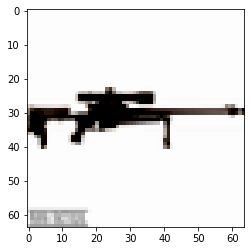

In [10]:
plt.imshow(dataset[13])

In [0]:
from __future__ import print_function, division

from keras.datasets import mnist
from keras.layers import Input, Dense, Reshape, Flatten, Dropout
from keras.layers import BatchNormalization, Activation, ZeroPadding2D
from keras.layers.advanced_activations import LeakyReLU
from keras.layers.convolutional import UpSampling2D, Conv2D
from keras.models import Sequential, Model
from keras.optimizers import Adam


In [12]:
class DCGAN():
    def __init__(self):
        # Input shape
        self.img_rows = 64
        self.img_cols = 64
        self.channels = 3
        self.img_shape = (self.img_rows, self.img_cols, self.channels)
        self.latent_dim = 100

        optimizer = Adam(0.0002, 0.5)

        # Build and compile the discriminator
        self.discriminator = self.build_discriminator()
        self.discriminator.compile(loss='binary_crossentropy',
            optimizer=optimizer,
            metrics=['accuracy'])

        # Build the generator
        self.generator = self.build_generator()

        # The generator takes noise as input and generates imgs
        z = Input(shape=(self.latent_dim,))
        img = self.generator(z)

        # For the combined model we will only train the generator
        self.discriminator.trainable = False

        # The discriminator takes generated images as input and determines validity
        valid = self.discriminator(img)

        # The combined model  (stacked generator and discriminator)
        # Trains the generator to fool the discriminator
        self.combined = Model(z, valid)
        self.combined.compile(loss='binary_crossentropy', optimizer=optimizer)

    def build_generator(self):

        model = Sequential()

        model.add(Dense(256 * 8 * 8, activation="relu", input_dim=self.latent_dim))
        model.add(Reshape((8, 8, 256)))
        model.add(UpSampling2D())
        model.add(Conv2D(128, kernel_size=3, padding="same"))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Activation("relu"))
        model.add(UpSampling2D())
        model.add(Conv2D(64, kernel_size=3, padding="same"))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Activation("relu"))

        model.add(UpSampling2D())
        model.add(Conv2D(32, kernel_size=3, padding="same"))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Activation("relu"))

        model.add(Conv2D(self.channels, kernel_size=3, padding="same"))
        model.add(Activation("tanh"))

        model.summary()

        noise = Input(shape=(self.latent_dim,))
        img = model(noise)

        return Model(noise, img)

    def build_discriminator(self):

        model = Sequential()

        model.add(Conv2D(32, kernel_size=3, strides=2, input_shape=self.img_shape, padding="same"))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dropout(0.25))
        model.add(Conv2D(64, kernel_size=3, strides=2, padding="same"))
        #model.add(ZeroPadding2D(padding=((0,1),(0,1))))
        model.add(BatchNormalization(momentum=0.8))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dropout(0.25))
        model.add(Conv2D(128, kernel_size=3, strides=2, padding="same"))
        model.add(BatchNormalization(momentum=0.8))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dropout(0.25))
        model.add(Conv2D(256, kernel_size=3, strides=1, padding="same"))
        model.add(BatchNormalization(momentum=0.8))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dropout(0.25))
        model.add(Flatten())
        model.add(Dense(1, activation='sigmoid'))

        model.summary()

        img = Input(shape=self.img_shape)
        validity = model(img)

        return Model(img, validity)

    def train(self, epochs, batch_size=128, save_interval=50):

        # Load the dataset
        #(X_train, _), (_, _) = mnist.load_data()
        X_train = dataset
        # Rescale -1 to 1
        #X_train = X_train / 127.5 - 1.
        #X_train = np.expand_dims(X_train, axis=3)
        print (X_train.shape)

        # Adversarial ground truths
        valid = np.ones((batch_size, 1))
        fake = np.zeros((batch_size, 1))

        for epoch in range(epochs):

            # ---------------------
            #  Train Discriminator
            # ---------------------

            # Select a random half of images
            idx = np.random.randint(0, X_train.shape[0], batch_size)
            imgs = X_train[idx]

            # Sample noise and generate a batch of new images
            noise = np.random.normal(0, 1, (batch_size, self.latent_dim))
            gen_imgs = self.generator.predict(noise)

            # Train the discriminator (real classified as ones and generated as zeros)
            d_loss_real = self.discriminator.train_on_batch(imgs, valid)
            d_loss_fake = self.discriminator.train_on_batch(gen_imgs, fake)
            d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

            # ---------------------
            #  Train Generator
            # ---------------------

            # Train the generator (wants discriminator to mistake images as real)
            g_loss = self.combined.train_on_batch(noise, valid)

            # Plot the progress
            print ("%d [D loss: %f, acc.: %.2f%%] [G loss: %f]" % (epoch, d_loss[0], 100*d_loss[1], g_loss))

            # If at save interval => save generated image samples
            if epoch % save_interval == 0:
                self.save_imgs(epoch)

    def save_imgs(self, epoch):
        r, c = 5, 5
        noise = np.random.normal(0, 1, (r * c, self.latent_dim))
        gen_imgs = self.generator.predict(noise)

        # Rescale images 0 - 1
        gen_imgs = 0.5 * gen_imgs + 0.5

        fig, axs = plt.subplots(r, c)
        cnt = 0
        for i in range(r):
            for j in range(c):
                axs[i,j].imshow(gen_imgs[cnt, :,:,:])
                axs[i,j].axis('off')
                cnt += 1
        fig.savefig("drive/My Drive/DCGan_Results/riffle_%d.png" % epoch)
        plt.close()


if __name__ == '__main__':
    dcgan = DCGAN()
    dcgan.train(epochs=10000, batch_size=32, save_interval=100)





Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.







Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 32, 32, 32)        896       
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 32, 32, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 16, 16, 64)        18496     
_________________________________________________________________
batch_normalization_1 (Batch (None, 16, 16, 64)        256       
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 16, 16, 64)        0    

/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:493: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:493: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


0 [D loss: 1.249042, acc.: 40.62%] [G loss: 0.691952]


/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:493: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


1 [D loss: 0.838624, acc.: 54.69%] [G loss: 1.078069]
2 [D loss: 0.666627, acc.: 62.50%] [G loss: 1.766452]
3 [D loss: 0.568964, acc.: 76.56%] [G loss: 2.086594]
4 [D loss: 0.732051, acc.: 59.38%] [G loss: 1.511589]
5 [D loss: 0.713420, acc.: 54.69%] [G loss: 1.446139]
6 [D loss: 0.509747, acc.: 70.31%] [G loss: 1.934832]
7 [D loss: 0.449111, acc.: 85.94%] [G loss: 1.619801]
8 [D loss: 0.443789, acc.: 92.19%] [G loss: 1.687569]
9 [D loss: 0.698390, acc.: 90.62%] [G loss: 2.200327]
10 [D loss: 0.323755, acc.: 95.31%] [G loss: 2.043767]
11 [D loss: 0.556813, acc.: 85.94%] [G loss: 1.664541]
12 [D loss: 0.334450, acc.: 92.19%] [G loss: 2.042754]
13 [D loss: 0.305112, acc.: 93.75%] [G loss: 2.368833]
14 [D loss: 0.608181, acc.: 90.62%] [G loss: 2.135589]
15 [D loss: 0.337886, acc.: 92.19%] [G loss: 2.673666]
16 [D loss: 0.515188, acc.: 92.19%] [G loss: 2.189221]
17 [D loss: 0.508304, acc.: 87.50%] [G loss: 2.275437]
18 [D loss: 0.376692, acc.: 93.75%] [G loss: 2.293773]
19 [D loss: 0.41516

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


2201 [D loss: 0.016845, acc.: 100.00%] [G loss: 3.850388]
2202 [D loss: 0.008604, acc.: 100.00%] [G loss: 13.614142]
2203 [D loss: 0.092778, acc.: 98.44%] [G loss: 4.412587]
2204 [D loss: 0.123347, acc.: 96.88%] [G loss: 4.565650]
2205 [D loss: 0.227460, acc.: 90.62%] [G loss: 3.264588]
2206 [D loss: 0.016273, acc.: 100.00%] [G loss: 10.145651]
2207 [D loss: 0.779481, acc.: 73.44%] [G loss: 8.773133]
2208 [D loss: 0.489589, acc.: 76.56%] [G loss: 10.747401]
2209 [D loss: 0.371087, acc.: 93.75%] [G loss: 4.888609]
2210 [D loss: 0.174203, acc.: 96.88%] [G loss: 4.790537]
2211 [D loss: 0.265447, acc.: 95.31%] [G loss: 1.654155]
2212 [D loss: 0.239588, acc.: 90.62%] [G loss: 3.635897]
2213 [D loss: 0.207231, acc.: 95.31%] [G loss: 5.538138]
2214 [D loss: 0.063092, acc.: 100.00%] [G loss: 4.335172]
2215 [D loss: 0.031013, acc.: 100.00%] [G loss: 4.712167]
2216 [D loss: 0.124720, acc.: 96.88%] [G loss: 5.543258]
2217 [D loss: 0.316782, acc.: 92.19%] [G loss: 3.502130]
2218 [D loss: 0.044397,

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


4001 [D loss: 0.114804, acc.: 96.88%] [G loss: 10.717128]
4002 [D loss: 0.151027, acc.: 95.31%] [G loss: 6.830303]
4003 [D loss: 0.112413, acc.: 96.88%] [G loss: 2.699787]
4004 [D loss: 0.115459, acc.: 100.00%] [G loss: 5.666451]
4005 [D loss: 0.028904, acc.: 100.00%] [G loss: 7.374402]
4006 [D loss: 0.397248, acc.: 79.69%] [G loss: 10.190485]
4007 [D loss: 0.316871, acc.: 87.50%] [G loss: 4.376390]
4008 [D loss: 0.081185, acc.: 96.88%] [G loss: 10.374680]
4009 [D loss: 0.003559, acc.: 100.00%] [G loss: 6.050715]
4010 [D loss: 0.023070, acc.: 100.00%] [G loss: 4.377861]
4011 [D loss: 0.063266, acc.: 98.44%] [G loss: 4.058113]
4012 [D loss: 0.163025, acc.: 96.88%] [G loss: 6.155382]
4013 [D loss: 0.003913, acc.: 100.00%] [G loss: 6.336457]
4014 [D loss: 0.356695, acc.: 79.69%] [G loss: 5.175607]
4015 [D loss: 0.066461, acc.: 98.44%] [G loss: 9.957031]
4016 [D loss: 0.420102, acc.: 78.12%] [G loss: 3.025765]
4017 [D loss: 0.006168, acc.: 100.00%] [G loss: 1.406131]
4018 [D loss: 1.069667

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


4401 [D loss: 0.271905, acc.: 92.19%] [G loss: 4.705314]
4402 [D loss: 0.005222, acc.: 100.00%] [G loss: 2.420976]
4403 [D loss: 0.004451, acc.: 100.00%] [G loss: 3.711229]
4404 [D loss: 0.011262, acc.: 100.00%] [G loss: 2.699808]
4405 [D loss: 1.439949, acc.: 57.81%] [G loss: 6.473990]
4406 [D loss: 0.062381, acc.: 100.00%] [G loss: 13.073449]
4407 [D loss: 0.495768, acc.: 64.06%] [G loss: 9.991213]
4408 [D loss: 0.022644, acc.: 100.00%] [G loss: 10.426031]
4409 [D loss: 0.003113, acc.: 100.00%] [G loss: 6.500634]
4410 [D loss: 0.429494, acc.: 75.00%] [G loss: 4.036311]
4411 [D loss: 0.363135, acc.: 81.25%] [G loss: 7.148594]
4412 [D loss: 0.697956, acc.: 60.94%] [G loss: 11.364061]
4413 [D loss: 0.035601, acc.: 100.00%] [G loss: 6.185947]
4414 [D loss: 0.508982, acc.: 65.62%] [G loss: 6.402526]
4415 [D loss: 0.830010, acc.: 62.50%] [G loss: 7.483518]
4416 [D loss: 0.048030, acc.: 100.00%] [G loss: 6.366881]
4417 [D loss: 0.301641, acc.: 82.81%] [G loss: 8.410703]
4418 [D loss: 0.0573

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


5201 [D loss: 0.043954, acc.: 100.00%] [G loss: 6.215778]
5202 [D loss: 0.022288, acc.: 100.00%] [G loss: 7.570309]
5203 [D loss: 0.004159, acc.: 100.00%] [G loss: 7.205011]
5204 [D loss: 0.201061, acc.: 95.31%] [G loss: 6.458827]
5205 [D loss: 0.003148, acc.: 100.00%] [G loss: 9.043113]
5206 [D loss: 0.124817, acc.: 98.44%] [G loss: 5.791490]
5207 [D loss: 0.020269, acc.: 100.00%] [G loss: 7.495680]
5208 [D loss: 0.033221, acc.: 100.00%] [G loss: 6.033794]
5209 [D loss: 0.004054, acc.: 100.00%] [G loss: 7.348687]
5210 [D loss: 0.037630, acc.: 98.44%] [G loss: 8.335426]
5211 [D loss: 0.000383, acc.: 100.00%] [G loss: 4.560013]
5212 [D loss: 0.000361, acc.: 100.00%] [G loss: 10.592641]
5213 [D loss: 0.016368, acc.: 100.00%] [G loss: 4.889908]
5214 [D loss: 0.006866, acc.: 100.00%] [G loss: 5.678911]
5215 [D loss: 0.006748, acc.: 100.00%] [G loss: 4.293810]
5216 [D loss: 0.523547, acc.: 62.50%] [G loss: 7.714016]
5217 [D loss: 0.058202, acc.: 100.00%] [G loss: 9.694820]
5218 [D loss: 1.1

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


5301 [D loss: 0.017209, acc.: 100.00%] [G loss: 7.897684]
5302 [D loss: 0.005964, acc.: 100.00%] [G loss: 7.799308]
5303 [D loss: 0.103883, acc.: 100.00%] [G loss: 4.928247]
5304 [D loss: 0.130542, acc.: 98.44%] [G loss: 6.140386]
5305 [D loss: 0.007275, acc.: 100.00%] [G loss: 9.346062]
5306 [D loss: 0.001139, acc.: 100.00%] [G loss: 9.897696]
5307 [D loss: 0.167955, acc.: 96.88%] [G loss: 8.317183]
5308 [D loss: 0.161521, acc.: 95.31%] [G loss: 3.177529]
5309 [D loss: 0.071873, acc.: 98.44%] [G loss: 6.551744]
5310 [D loss: 0.090527, acc.: 98.44%] [G loss: 4.287382]
5311 [D loss: 0.001628, acc.: 100.00%] [G loss: 3.832267]
5312 [D loss: 0.213280, acc.: 90.62%] [G loss: 5.557546]
5313 [D loss: 0.898239, acc.: 50.00%] [G loss: 5.070989]
5314 [D loss: 0.105390, acc.: 96.88%] [G loss: 3.119400]
5315 [D loss: 0.486944, acc.: 64.06%] [G loss: 9.109962]
5316 [D loss: 0.264876, acc.: 85.94%] [G loss: 7.349581]
5317 [D loss: 0.054374, acc.: 100.00%] [G loss: 4.840737]
5318 [D loss: 0.004925, 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


5701 [D loss: 0.007949, acc.: 100.00%] [G loss: 7.341230]
5702 [D loss: 0.005436, acc.: 100.00%] [G loss: 10.026629]
5703 [D loss: 0.017972, acc.: 100.00%] [G loss: 9.275894]
5704 [D loss: 0.024969, acc.: 100.00%] [G loss: 5.549831]
5705 [D loss: 0.099010, acc.: 100.00%] [G loss: 6.213677]
5706 [D loss: 0.086631, acc.: 98.44%] [G loss: 9.000515]
5707 [D loss: 0.015597, acc.: 100.00%] [G loss: 9.533065]
5708 [D loss: 0.043756, acc.: 100.00%] [G loss: 4.759583]
5709 [D loss: 0.010377, acc.: 100.00%] [G loss: 5.839463]
5710 [D loss: 0.006135, acc.: 100.00%] [G loss: 7.099420]
5711 [D loss: 0.016856, acc.: 100.00%] [G loss: 10.502306]
5712 [D loss: 0.061944, acc.: 98.44%] [G loss: 4.729818]
5713 [D loss: 0.023134, acc.: 100.00%] [G loss: 3.945030]
5714 [D loss: 0.221134, acc.: 90.62%] [G loss: 5.943616]
5715 [D loss: 0.049261, acc.: 100.00%] [G loss: 7.653861]
5716 [D loss: 0.031281, acc.: 100.00%] [G loss: 5.880935]
5717 [D loss: 0.004274, acc.: 100.00%] [G loss: 3.369540]
5718 [D loss: 0

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


6301 [D loss: 0.053815, acc.: 98.44%] [G loss: 6.327708]
6302 [D loss: 0.130470, acc.: 95.31%] [G loss: 6.194945]
6303 [D loss: 0.029369, acc.: 100.00%] [G loss: 9.947767]
6304 [D loss: 0.011694, acc.: 100.00%] [G loss: 6.592409]
6305 [D loss: 0.040952, acc.: 98.44%] [G loss: 4.745673]
6306 [D loss: 0.002501, acc.: 100.00%] [G loss: 8.774939]
6307 [D loss: 0.117509, acc.: 95.31%] [G loss: 6.318196]
6308 [D loss: 0.028348, acc.: 100.00%] [G loss: 6.823049]
6309 [D loss: 0.686636, acc.: 64.06%] [G loss: 6.497847]
6310 [D loss: 0.407005, acc.: 70.31%] [G loss: 11.857816]
6311 [D loss: 0.078743, acc.: 98.44%] [G loss: 11.598948]
6312 [D loss: 0.143073, acc.: 98.44%] [G loss: 5.949369]
6313 [D loss: 0.008535, acc.: 100.00%] [G loss: 4.788795]
6314 [D loss: 0.020317, acc.: 100.00%] [G loss: 5.978866]
6315 [D loss: 0.014226, acc.: 100.00%] [G loss: 2.636595]
6316 [D loss: 0.020312, acc.: 100.00%] [G loss: 7.474895]
6317 [D loss: 0.004824, acc.: 100.00%] [G loss: 2.868985]
6318 [D loss: 0.0079

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


7801 [D loss: 0.003877, acc.: 100.00%] [G loss: 12.662512]
7802 [D loss: 0.032417, acc.: 98.44%] [G loss: 8.095156]
7803 [D loss: 0.011165, acc.: 100.00%] [G loss: 5.976887]
7804 [D loss: 0.257408, acc.: 84.38%] [G loss: 11.365055]
7805 [D loss: 0.389122, acc.: 79.69%] [G loss: 5.782118]
7806 [D loss: 0.002483, acc.: 100.00%] [G loss: 10.782038]
7807 [D loss: 0.004983, acc.: 100.00%] [G loss: 7.042041]
7808 [D loss: 0.098670, acc.: 98.44%] [G loss: 8.538969]
7809 [D loss: 0.009670, acc.: 100.00%] [G loss: 4.929331]
7810 [D loss: 0.010521, acc.: 100.00%] [G loss: 10.454781]
7811 [D loss: 0.002996, acc.: 100.00%] [G loss: 10.505389]
7812 [D loss: 0.248398, acc.: 89.06%] [G loss: 9.690872]
7813 [D loss: 0.328211, acc.: 78.12%] [G loss: 8.158399]
7814 [D loss: 0.017079, acc.: 100.00%] [G loss: 11.047041]
7815 [D loss: 0.100244, acc.: 95.31%] [G loss: 9.643551]
7816 [D loss: 0.005083, acc.: 100.00%] [G loss: 8.395468]
7817 [D loss: 0.000109, acc.: 100.00%] [G loss: 9.956112]
7818 [D loss: 0

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


8001 [D loss: 0.005019, acc.: 100.00%] [G loss: 12.749954]
8002 [D loss: 0.003076, acc.: 100.00%] [G loss: 7.992974]
8003 [D loss: 0.009605, acc.: 100.00%] [G loss: 4.990870]
8004 [D loss: 0.006371, acc.: 100.00%] [G loss: 7.458068]
8005 [D loss: 0.019620, acc.: 100.00%] [G loss: 4.263057]
8006 [D loss: 0.003912, acc.: 100.00%] [G loss: 8.850536]
8007 [D loss: 0.047220, acc.: 100.00%] [G loss: 8.392503]
8008 [D loss: 0.045884, acc.: 100.00%] [G loss: 7.922525]
8009 [D loss: 0.008202, acc.: 100.00%] [G loss: 10.270257]
8010 [D loss: 0.032326, acc.: 100.00%] [G loss: 7.514563]
8011 [D loss: 0.012752, acc.: 100.00%] [G loss: 5.781049]
8012 [D loss: 0.206906, acc.: 90.62%] [G loss: 6.035880]
8013 [D loss: 0.012896, acc.: 100.00%] [G loss: 2.075933]
8014 [D loss: 1.125138, acc.: 53.12%] [G loss: 10.166889]
8015 [D loss: 0.046110, acc.: 100.00%] [G loss: 13.655531]
8016 [D loss: 0.023421, acc.: 100.00%] [G loss: 9.315733]
8017 [D loss: 0.037418, acc.: 98.44%] [G loss: 13.559757]
8018 [D loss

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


8101 [D loss: 0.157306, acc.: 93.75%] [G loss: 8.598889]
8102 [D loss: 0.118124, acc.: 100.00%] [G loss: 11.699223]
8103 [D loss: 0.018578, acc.: 100.00%] [G loss: 5.498162]
8104 [D loss: 0.033702, acc.: 100.00%] [G loss: 3.216161]
8105 [D loss: 0.025804, acc.: 100.00%] [G loss: 7.349923]
8106 [D loss: 0.041060, acc.: 100.00%] [G loss: 5.095256]
8107 [D loss: 0.007283, acc.: 100.00%] [G loss: 9.581550]
8108 [D loss: 0.179686, acc.: 92.19%] [G loss: 5.522338]
8109 [D loss: 0.321160, acc.: 79.69%] [G loss: 3.415637]
8110 [D loss: 0.033845, acc.: 100.00%] [G loss: 6.656336]
8111 [D loss: 0.000251, acc.: 100.00%] [G loss: 10.165553]
8112 [D loss: 0.008240, acc.: 100.00%] [G loss: 7.234535]
8113 [D loss: 0.007973, acc.: 100.00%] [G loss: 6.320210]
8114 [D loss: 0.000998, acc.: 100.00%] [G loss: 7.994836]
8115 [D loss: 0.263017, acc.: 84.38%] [G loss: 4.466891]
8116 [D loss: 0.006401, acc.: 100.00%] [G loss: 10.428770]
8117 [D loss: 0.314813, acc.: 76.56%] [G loss: 7.716280]
8118 [D loss: 0.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


8401 [D loss: 0.021045, acc.: 100.00%] [G loss: 13.240179]
8402 [D loss: 0.017923, acc.: 100.00%] [G loss: 9.006414]
8403 [D loss: 0.010011, acc.: 100.00%] [G loss: 11.502960]
8404 [D loss: 0.671466, acc.: 59.38%] [G loss: 5.816286]
8405 [D loss: 0.023743, acc.: 100.00%] [G loss: 3.736860]
8406 [D loss: 0.120654, acc.: 96.88%] [G loss: 6.119063]
8407 [D loss: 0.002036, acc.: 100.00%] [G loss: 10.439001]
8408 [D loss: 0.043108, acc.: 98.44%] [G loss: 9.986445]
8409 [D loss: 0.007821, acc.: 100.00%] [G loss: 7.278432]
8410 [D loss: 0.008917, acc.: 100.00%] [G loss: 13.769402]
8411 [D loss: 0.051547, acc.: 100.00%] [G loss: 9.739443]
8412 [D loss: 0.001541, acc.: 100.00%] [G loss: 11.956824]
8413 [D loss: 0.021982, acc.: 100.00%] [G loss: 8.887093]
8414 [D loss: 0.016796, acc.: 100.00%] [G loss: 7.686470]
8415 [D loss: 0.016661, acc.: 100.00%] [G loss: 5.743145]
8416 [D loss: 0.002826, acc.: 100.00%] [G loss: 7.862617]
8417 [D loss: 0.005750, acc.: 100.00%] [G loss: 5.147394]
8418 [D loss

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


9301 [D loss: 0.025946, acc.: 98.44%] [G loss: 5.038993]
9302 [D loss: 0.243581, acc.: 93.75%] [G loss: 11.597118]
9303 [D loss: 0.383885, acc.: 76.56%] [G loss: 6.667761]
9304 [D loss: 1.695819, acc.: 60.94%] [G loss: 14.862643]
9305 [D loss: 0.015217, acc.: 100.00%] [G loss: 14.595274]
9306 [D loss: 0.298829, acc.: 95.31%] [G loss: 8.843596]
9307 [D loss: 0.385852, acc.: 75.00%] [G loss: 2.537669]
9308 [D loss: 0.322126, acc.: 81.25%] [G loss: 11.267879]
9309 [D loss: 0.018971, acc.: 100.00%] [G loss: 12.897274]
9310 [D loss: 0.106395, acc.: 95.31%] [G loss: 12.615591]
9311 [D loss: 0.000475, acc.: 100.00%] [G loss: 5.919793]
9312 [D loss: 0.016170, acc.: 100.00%] [G loss: 14.135692]
9313 [D loss: 0.003279, acc.: 100.00%] [G loss: 12.189025]
9314 [D loss: 0.000027, acc.: 100.00%] [G loss: 6.805333]
9315 [D loss: 0.001310, acc.: 100.00%] [G loss: 7.799825]
9316 [D loss: 0.000391, acc.: 100.00%] [G loss: 8.457440]
9317 [D loss: 0.000318, acc.: 100.00%] [G loss: 12.940552]
9318 [D loss:

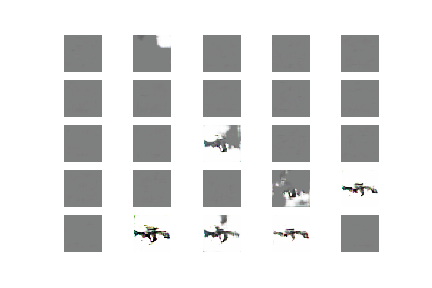

In [13]:

from IPython.display import Image 
pil_img = Image(filename='drive/My Drive/DCGan_Results/riffle_5000.png')
display(pil_img)